# Part 1: Data Preparation and Exploration
### Data Loading:

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load the dataset
data = pd.read_csv('exchange_rate.csv', parse_dates=['date'], dayfirst=True, index_col='date')

# Ensure the index is a datetime index
data.index = pd.to_datetime(data.index)
data = data.asfreq('W')  # Set the frequency to daily

# Display the first few rows of the dataset
data

,Ex_rate
date,
1990-01-07,0.788600
1990-01-14,0.795400
1990-01-21,0.768500
1990-01-28,0.749300
1990-02-04,0.758600
...,...
2010-09-12,0.745045
2010-09-19,0.744990
2010-09-26,0.729714


### Initial exploration

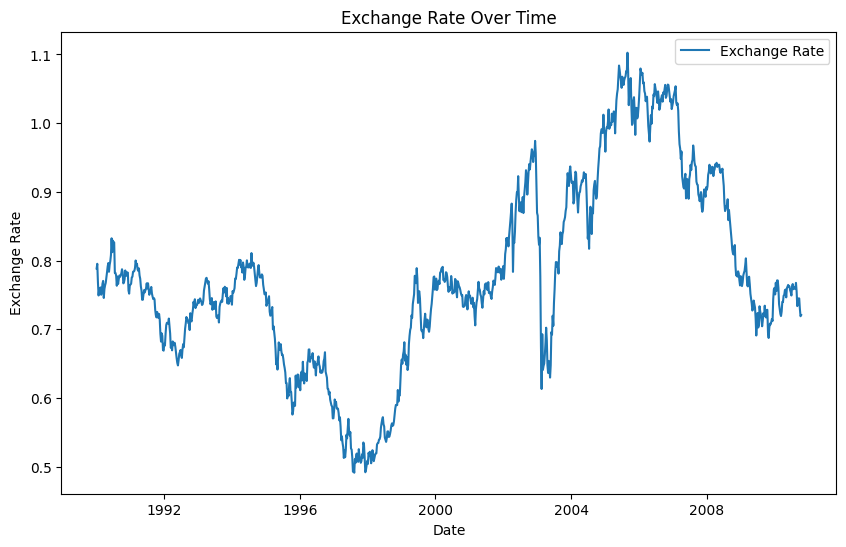

In [2]:
import matplotlib.pyplot as plt

# Plotting the time series for Exchange_rate
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Data Preprocessing:

In [3]:
# Check for missing values
print(data.isnull().sum())

# Handling missing values by forward filling
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Verify that there are no missing values left
print(data.isnull().sum())

Ex_rate    0
dtype: int64
Ex_rate    0
dtype: int64


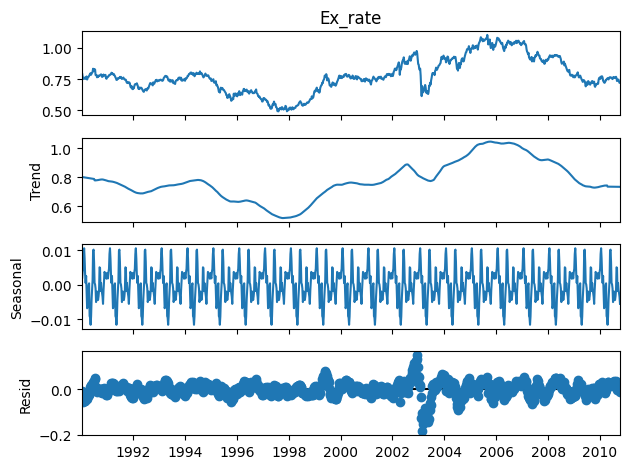

In [4]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(data['Ex_rate'], model='additive', 
                            extrapolate_trend='freq') #additive or multiplicative is data specific

fig = decomposition.plot()
plt.show()

# Part 2: Model Building - ARIMA
### Stationarity and Differencing
##### Check the stationarity of the time series and perform differencing if needed.

ADF Statistic: -1.7747762293125893
p-value: 0.39305453163941323


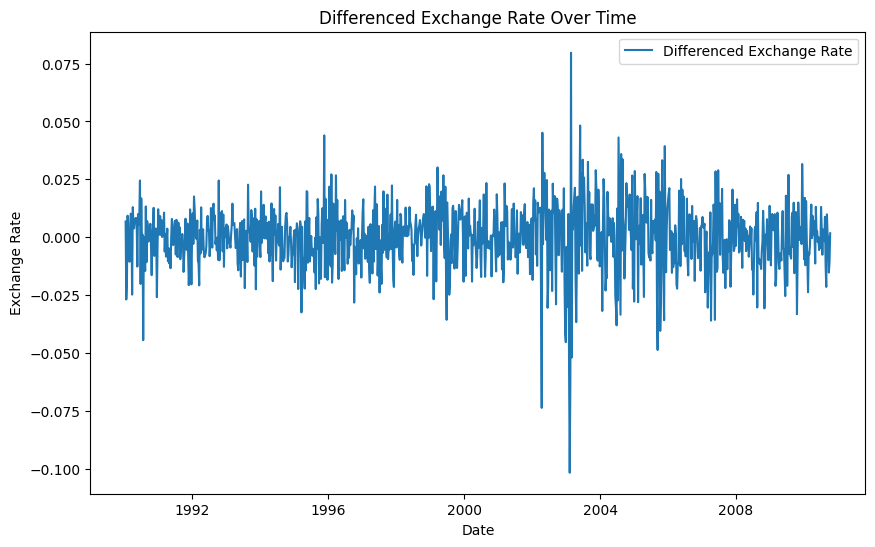

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(data['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If the p-value is greater than 0.05, the series is non-stationary and we need to difference it
if result[1] > 0.05:
    data['Exchange_rate_diff'] = data['Ex_rate'].diff().dropna()
else:
    data['Exchange_rate_diff'] = data['Ex_rate']

# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(data['Exchange_rate_diff'], label='Differenced Exchange Rate')
plt.title('Differenced Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Parameter Selection for ARIMA

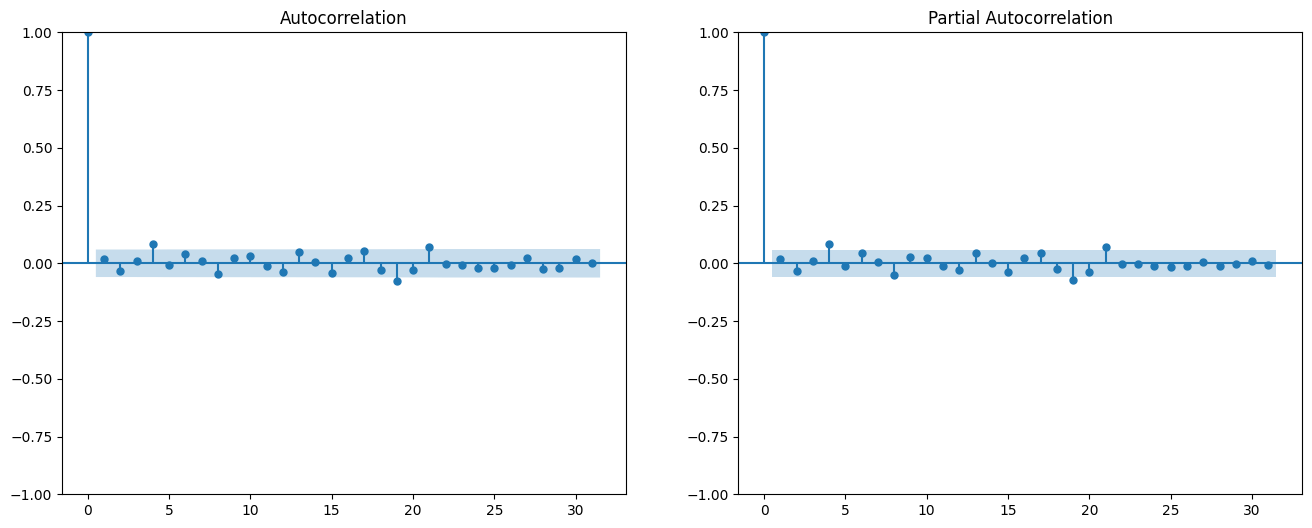

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data['Exchange_rate_diff'].dropna(), ax=axes[0])
plot_pacf(data['Exchange_rate_diff'].dropna(), ax=axes[1])
plt.show()

### Model Fitting:

In [7]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore", message="No frequency information was provided")

# Define the ARIMA model
arima_model = ARIMA(data['Ex_rate'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Summary of the ARIMA model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 1084
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3097.115
Date:                Thu, 23 May 2024   AIC                          -6188.231
Time:                        19:06:30   BIC                          -6173.268
Sample:                    01-07-1990   HQIC                         -6182.566
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6354      0.599     -1.061      0.289      -1.809       0.538
ma.L1          0.6516      0.594      1.097      0.273      -0.513       1.816
sigma2         0.0002    4.6e-06     41.807      0.0

### Visualize the predicted values against the actual values.

In [8]:
data.shape

(1084, 2)

MAE: 0.1783447018941481
RMSE: 0.20585787099484537


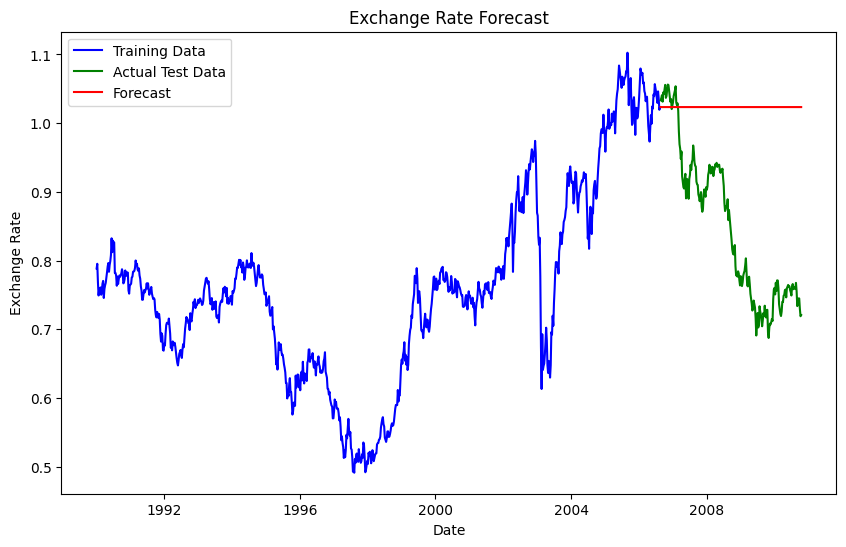

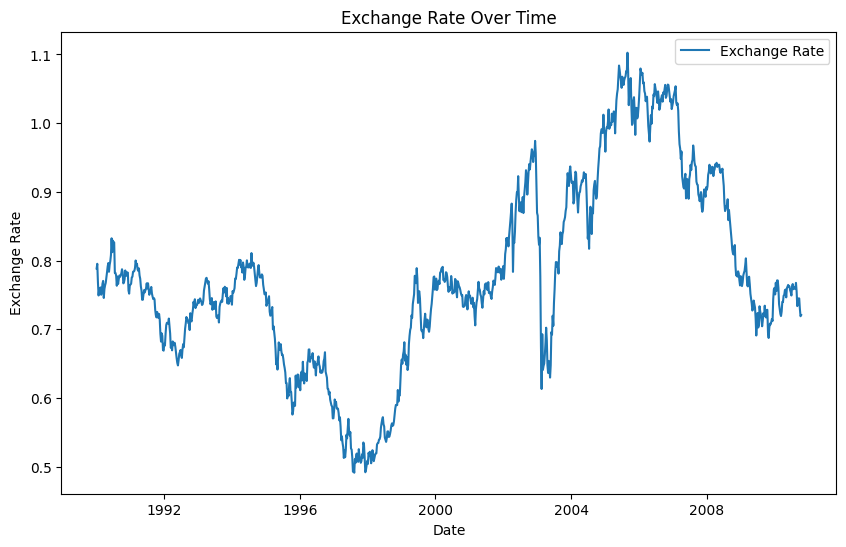

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data into training and testing sets
train = data.iloc[:-217]  # Using all but the last 1518 days for training
test = data.iloc[-217:]   # Using the last 1518 days for testing

# Train the ARIMA model on the training data
arima_model = ARIMA(train['Ex_rate'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecasting for the testing period
forecast_steps = len(test)
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test.index[0], periods=forecast_steps, freq='W')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Calculate error metrics for the test period
mae = mean_absolute_error(test['Ex_rate'], forecast_series)
rmse = mean_squared_error(test['Ex_rate'], forecast_series, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Visualize the actual values alongside the predicted values
plt.figure(figsize=(10, 6))
plt.plot(train['Ex_rate'], label='Training Data', color='blue')
plt.plot(test['Ex_rate'], label='Actual Test Data', color='green')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# For Comparison
# Plotting the time series for Exchange_rate
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Diagnostics:

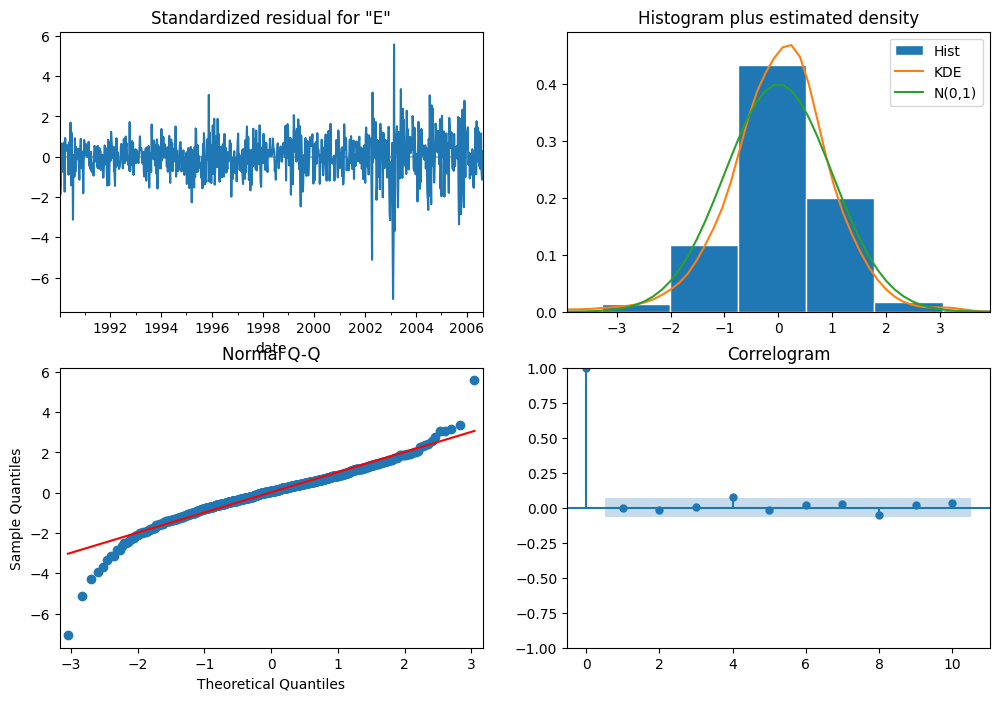

In [10]:
# Diagnostics plot for ARIMA model
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

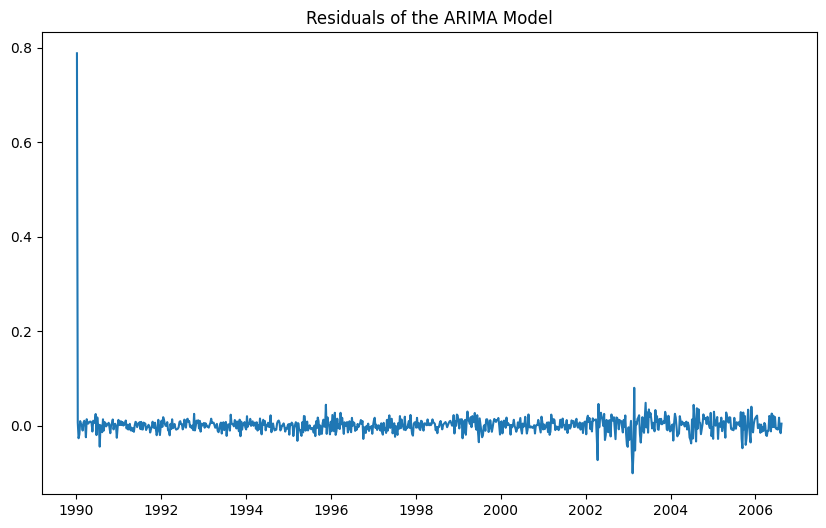

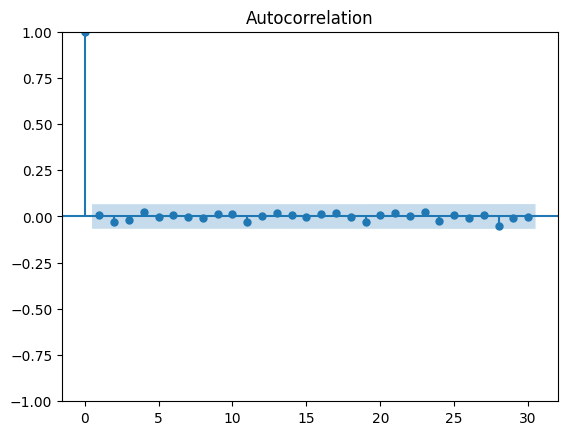

In [11]:
# Plot residuals
residuals = arima_result.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.show()

# Plot ACF of residuals
plot_acf(residuals)
plt.show()

### Forecasting:

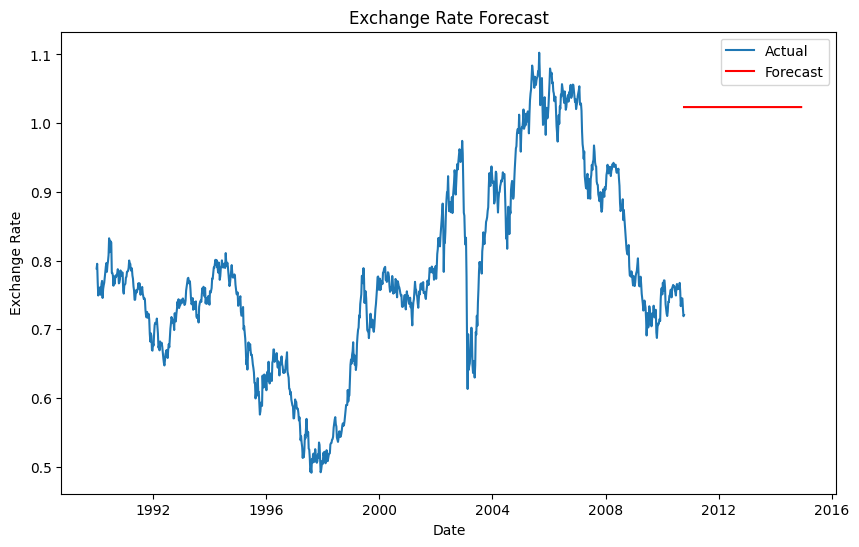

In [12]:
# Train the ARIMA model on the training data
arima_model = ARIMA(train['Ex_rate'], order=(1, 1, 0))
arima_result = arima_model.fit()

# Forecasting 
forecast_steps = len(test)
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps, freq='W')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## SARIMAX MODEL

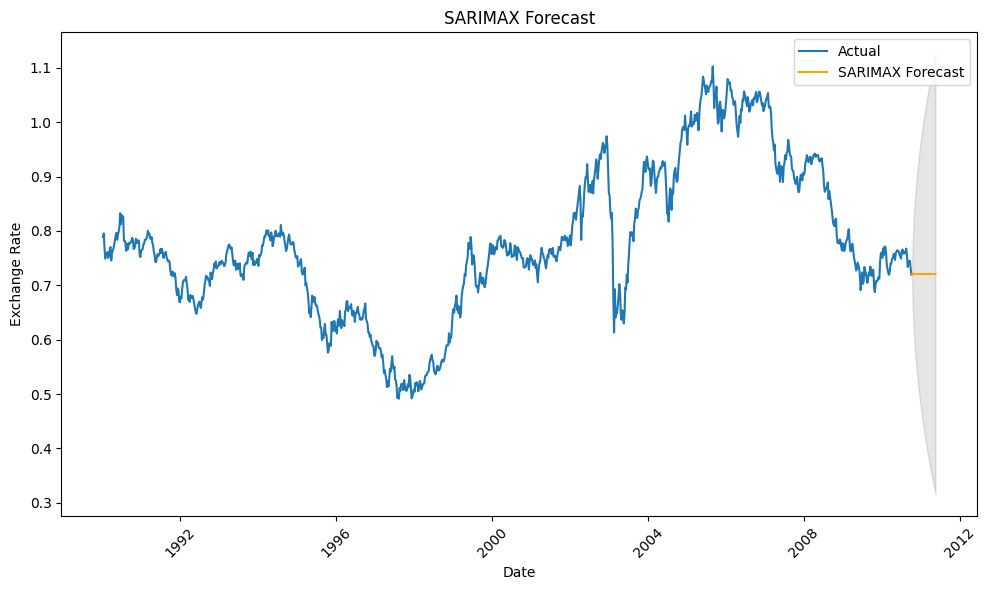

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit the ARIMA model with chosen parameters
p, d, q = 1, 1, 1  
arima_model = SARIMAX(data['Ex_rate'], order=(p, d, q)).fit()

# Perform out-of-sample forecasting
n_forecast = len(test)
arima_forecast = arima_model.get_forecast(steps=n_forecast)
arima_forecast_data = arima_forecast.conf_int(alpha=0.05)
arima_forecast_data['forecast'] = arima_forecast.predicted_mean

# Ensure forecast index is datetime and aligns correctly
forecast_index = pd.date_range(start=data.index[-1], periods=n_forecast + 1, inclusive='right')
arima_forecast_data.index = forecast_index

# Extend the original data with forecasted values for plotting
extended_data = pd.concat([data, arima_forecast_data['forecast']], axis=1)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(extended_data.index, extended_data['forecast'], label='SARIMAX Forecast', color='orange')
plt.fill_between(arima_forecast_data.index, arima_forecast_data.iloc[:, 0], arima_forecast_data.iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Model Building - Exponential Smoothing
### Model Selection

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings("ignore", message="No frequency information was provided")

# Define the Holt-Winters model
hw_model = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal=None, seasonal_periods=12)
hw_result = hw_model.fit()

# Summary of the Holt-Winters model
print(hw_result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 1084
Model:             ExponentialSmoothing   SSE                              0.208
Optimized:                         True   AIC                          -9269.134
Trend:                         Additive   BIC                          -9249.181
Seasonal:                          None   AICC                         -9269.056
Seasonal Periods:                  None   Date:                 Thu, 23 May 2024
Box-Cox:                          False   Time:                         19:06:33
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend           9.5739e-

### Model Fitting and Forecasting

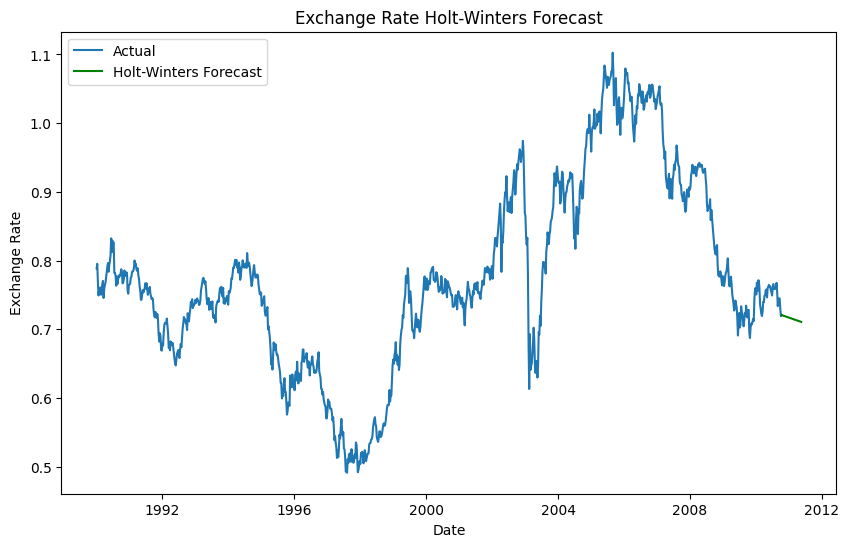

In [15]:
# Forecasting
hw_forecast = hw_result.forecast(steps=len(test))
hw_forecast_series = pd.Series(hw_forecast.values, index=forecast_index)

# Plotting the Holt-Winters forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(hw_forecast_series, label='Holt-Winters Forecast', color='green')
plt.title('Exchange Rate Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## Hypertuning

In [16]:
# Split data into training and testing sets
train = data.iloc[:-217]  
test = data.iloc[-217:]   

In [17]:
# Define the parameter grid for Holt-Winters Exponential Smoothing
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [7, 12, 30]  # Assuming daily data with weekly, monthly seasonality
}

# Generate all combinations of parameters
from itertools import product
params = list(product(param_grid['trend'], param_grid['seasonal'], param_grid['seasonal_periods']))

# Initialize variables to store the best parameters and the corresponding score
best_params = None
best_mae = float('inf')

# Perform Grid Search
for trend, seasonal, seasonal_periods in params:
    try:
        hw_model = ExponentialSmoothing(train['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        hw_result = hw_model.fit()
        hw_forecast = hw_result.forecast(steps=len(test))
        mae = mean_absolute_error(test['Ex_rate'], hw_forecast)
        
        # Update best parameters if current MAE is lower than the best MAE
        if mae < best_mae:
            best_mae = mae
            best_params = (trend, seasonal, seasonal_periods)
    except Exception as e:
        # Print the exception if occurs and continue
        print(f"Exception for parameters (trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}): {e}")
        continue

if best_params is not None:
    print(f"Best parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Seasonal Periods={best_params[2]}")
    print(f"Best MAE: {best_mae}")
else:
    print("No best parameters found.")

Best parameters: Trend=None, Seasonal=None, Seasonal Periods=7
Best MAE: 0.1783084054864453


MAE: 0.1783084054864453
RMSE: 0.2058173543823335


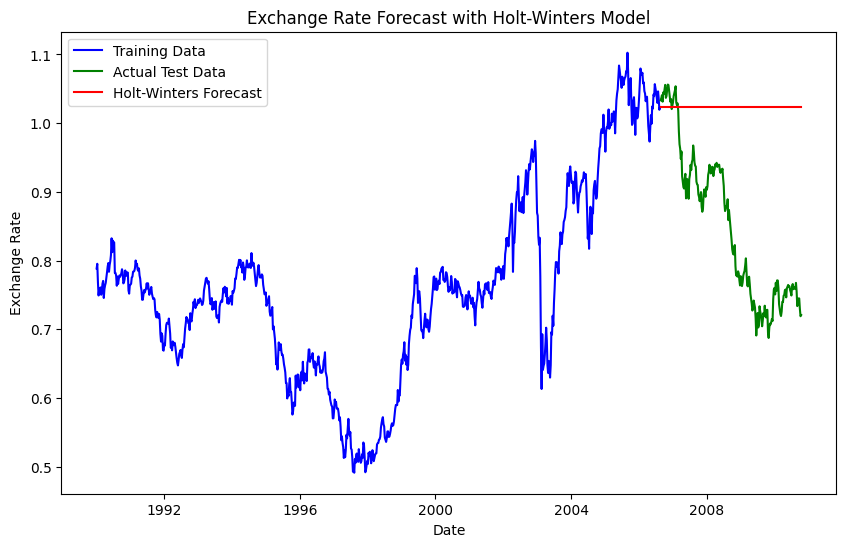

In [18]:
# Fit the model with the best parameters
hw_model = ExponentialSmoothing(train['Ex_rate'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=best_params[2])
hw_result = hw_model.fit()
hw_forecast = hw_result.forecast(steps=len(test))

# Calculate error metrics for the test period
mae = mean_absolute_error(test['Ex_rate'], hw_forecast)
rmse = mean_squared_error(test['Ex_rate'], hw_forecast, squared=False)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Visualize the actual values alongside the predicted values
plt.figure(figsize=(10, 6))
plt.plot(train['Ex_rate'], label='Training Data', color='blue')
plt.plot(test['Ex_rate'], label='Actual Test Data', color='green')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='red')
plt.title('Exchange Rate Forecast with Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Step 4: Evaluation and Comparison
### Compute Error Metrics

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate error metrics for ARIMA
mae_arima = mean_absolute_error(data['Ex_rate'][-217:], forecast_series)
rmse_arima = mean_squared_error(data['Ex_rate'][-217:], forecast_series, squared=False)
mape_arima = mean_absolute_percentage_error(data['Ex_rate'][-217:], forecast_series)

# Calculate error metrics for Holt-Winters
mae_hw = mean_absolute_error(data['Ex_rate'][-217:], hw_forecast_series)
rmse_hw = mean_squared_error(data['Ex_rate'][-217:], hw_forecast_series, squared=False)
mape_hw = mean_absolute_percentage_error(data['Ex_rate'][-217:], hw_forecast_series)

print(f"ARIMA Model - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}")
print(f"Holt-Winters Model - MAE: {mae_hw}, RMSE: {rmse_hw}, MAPE: {mape_hw}")

ARIMA Model - MAE: 0.17834504362117648, RMSE: 0.20585814821466447, MAPE: 41.98211548372281
Holt-Winters Model - MAE: 0.13444849616292825, RMSE: 0.17087650763565826, MAPE: nan
